In this notebook I'll implement the metropolis-hastings algorithm for the Ising model. We'll start by considering only one dimension (a chain of atoms). We will represent our system using an array whose elements are either -1 or +1 depending on the spin of the atom. We will also consider periodic boundary conditions - that is, the first atom is the neighbour of the last atom. In effect, we are simulating a loop of atoms.

Let's start by writing a function to calculate the energy of a state. Note that I do it in a slightly tricky way using array indexing. This is faster than a for loop, which is helpful because we will have to evaluate the energy many times.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import random

def getEnergy_1D_loopversion(state, B, J, mu):
    energy = 0
    for i in range(len(state)):
        # If the atom is the first in the chain
        if i==0:
            # Contribution from left neighbour. Left neighbour is last atom in the chain
            energy = energy - J*state[i]*state[-1]
            # Contribution from right neighbour
            energy = energy - J*state[i]*state[i+1]
            # Contribution from external field
            energy = energy - mu*B*state[i]
            
        # If the atom is the last in the chain
        elif i==len(state)-1:
            # Contribution from left neighbour. 
            energy = energy - J*state[i]*state[i-1]
            # Contribution from right neighbour. Right neighbour is the first in the chain
            energy = energy - J*state[i]*state[0]
            # Contribution from external field
            energy = energy - mu*B*state[i]            
        
        else:
            # Contribution from left neighbour
            energy = energy - J*state[i]*state[i-1]
            # Contribution from right neighbour
            energy = energy - J*state[i]*state[i+1]
            # Contribution from external field
            energy = energy - mu*B*state[i]
    return energy

def getEnergy_1D(state, B, J, mu):
    energy = 0
    # left neighbours
    energy = energy - J * (state[1:]*state[0:-1]).sum()
    # Deal with left neighbour of first spin
    energy = energy - J*state[0]*state[-1]
    
    # right neightbours
    energy = energy - J * (state[0:-1]*state[1:]).sum()
    # Deal with right neighbour of last spin
    energy = energy - J*state[-1]*state[0]
    
    # magnetic field
    energy = energy - (mu*B*state).sum()
    return energy
    

Let's do some quick checks: both methods should give the same value, and you can check these two examples by hand.

In [2]:
state = np.array([1, 1, 1, 1])
print(getEnergy_1D_loopversion(state, 0, 1, 1))
print(getEnergy_1D(state, 0, 1, 1))

state = np.array([1, 1, -1, -1])
print(getEnergy_1D_loopversion(state, 0, 1, 1))
print(getEnergy_1D(state, 0, 1, 1))

-8
-8
0
0


As an aside, we can time both verions of the function. You can see that it we have many atoms, the version that uses indexing is much faster.

In [3]:
from timeit import timeit
state = np.ones(10000)
tNoLoop = timeit('getEnergy_1D(state, 0, 1, 1)', number=100, globals=globals())
tLoop = timeit('getEnergy_1D_loopversion(state, 0, 1, 1)', number=100, globals=globals())
print('Loop version: %.2e s, indexing version: %.2e s. Indexing version is %.2f times faster than \
loop version'%(tLoop, tNoLoop, tLoop/tNoLoop))

Loop version: 2.16e+00 s, indexing version: 6.26e-03 s. Indexing version is 345.41 times faster than loop version


Now let's write a function that decides (randomly) whether a change from `state1` to `state2` should be accepted or rejected.

In [4]:
def acceptOrReject(E1, E2, beta):
    # Note we are defining beta = 1/kT. You should notice from the lesson and notes that every time either k or T appear in
    # the equations, they always appear in the combination 1/kT.
    deltaE = E2-E1
    
    if deltaE < 0:
        return True
    else:
        # This is the relative probability of state 2. We need to return True with probability R. Note 0<R<=1
        R = np.exp(-deltaE*beta)
        # To do this, we just choose a uniform random number, x,  between 0 and 1. The probability that the random number is
        # less than or equal to R is simply R. So we should accept if x<=R, and reject if x>R.
        x = np.random.random()
        if x<=R:
            return True
        else:
            return False
        

Now we can write a function that does implements the MH algorithm. It will return: an array of size N_steps representing the energy at each step, an array `states` of size N_steps * N_spins representing the state of the system at each timestep, and an array `finalState` representing the final state of the system

In [5]:
def do_MH(initialState, N_steps, beta, B=0, J=1, mu=1):
    N_spins = len(initialState)
    energies = np.zeros(N_steps)
    states = np.zeros((N_steps, N_spins))
    currentState = initialState
    
    for i in range(N_steps):
        states[i, :] = currentState
        currentEnergy = getEnergy_1D(currentState, B, J, mu)
        energies[i] = currentEnergy
        
        # To get a trial new state, randomly choose a spin, and then flip it
        # Choose a spin
        spinToFlip = np.random.randint(0, N_spins)
        # flip it
        currentState[spinToFlip] *= -1
        #Compute the new energy
        eTrial = getEnergy_1D(currentState, B, J, mu)
        #accept the change or reject it
        acceptOrRejectBoolean = acceptOrReject(currentEnergy, eTrial, beta)
        
        # if we reject it, we should flip the spin back. If we accept it, we don't need to do anything
        if not acceptOrRejectBoolean:
            currentState[spinToFlip] *= -1
    finalState = currentState
    return finalState, states, energies

    

Let's try it!

Experiment with the number of spins and magnetic field strength (but don't change `N_steps`- it should always be `10*N_spins`). You should notice that the energy settles down very quickly. When the temperature is higher (lower $\beta$), the energy takes longer to settle down.

Note that you can't directly enter the temperature in kelvin because I'm not using SI units for $J$ and $\mu$.

Also note that the magnetisation is defined to be $M = \sum_{i=1}^{N_\text{spins}} \sigma_i$. If the spins are mostly parallel, $|M|$ will be large. If they are not, $|M|$ will be small.

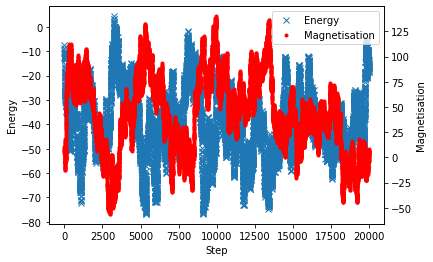

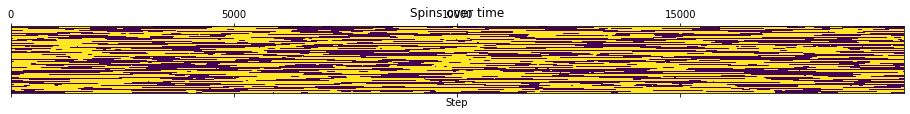

In [12]:
N_spins = 1000
N_steps = 20*N_spins
J = 0.2
mu = 0.33
# Note higher temperature means lower beta
beta = 0.2
B = 0.5

# We can start in any configuration because we need to take enough steps that the initial configuration doesn't matter.
# Let's start with a random initial configuration
initialState = np.ones(N_spins, dtype='int32')
for i in range(len(initialState)):
    # randomly flip each spin to create random initial state
    if np.random.random() > 0.5:
        initialState[i] = -initialState[i]
        
finalState, states, energies = do_MH(initialState, N_steps, beta, B, mu=mu, J=J)

magnetisation = states.sum(axis=1)
plt.figure()
ax = plt.gca()
l1, = ax.plot(np.arange(N_steps), energies, 'x')

plt.xlabel('Step')
plt.ylabel('Energy')
ax = plt.gca()
ax2 = ax.twinx()
l2, = ax2.plot(np.arange(N_steps), magnetisation, 'r.')
ax2.set_ylabel('Magnetisation')
plt.legend((l1, l2), ('Energy', 'Magnetisation'))
plt.show()

plt.matshow(states.T)
ax = plt.gca()
ax.set_aspect(1.5)
plt.xlabel('Step')
plt.yticks([])
plt.title('Spins over time')
plt.show()